In [1]:
from collections import defaultdict
import csv
import sys
import time
import gdal
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
import pandas as pd
from descartes.patch import PolygonPatch


import matplotlib.pyplot as plt
%matplotlib inline 


from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score, roc_auc_score
import os
import cv2
from shapely.wkt import loads as wkt_loads
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

import xgboost as xgb


Using TensorFlow backend.


In [2]:
from __future__ import division

In [3]:
CLASSES = {
        1 : 'Buildings',
        2 : 'Misc',
        3 : 'Road',
        4 : 'Track',
        5 : 'Trees',
        6 : 'Crops',
        7 : 'Waterway',
        8 : 'Standing water',
        9 : 'Vehicle Large',
        10 : 'Vehicle Small',
        }

COLORS = {
        1 : '0.7',
        2 : '0.4',
        3 : '#b35806',
        4 : '#dfc27d',
        5 : '#1b7837',
        6 : '#a6dba0',
        7 : '#74add1',
        8 : '#4575b4',
        9 : '#f46d43',
        10: '#d73027',
        }
ZORDER = {
        1 : 5,
        2 : 5,
        3 : 4,
        4 : 1,
        5 : 3,
        6 : 2,
        7 : 7,
        8 : 8,
        9 : 9,
        10: 10,
        }    

3 bands traditional RGB

# Overview of data 3 bands and 16 bands


# 16 bands

3 bands     3396*3349*3
Pancromatic  450-800nm     0.31m     pixel 3391*3348
8 multispectral  400-1040nm     1.24m     pixel  848*837*8
8 SWIR 1195-2365nm      7.5m    pixel   136*134*8


# View raster data

In [4]:
# try 3 bands first
from gdalconst import *
#current path '/Users/tianbaili/Desktop/data science/kaggle'
img_filename_3bands = os.getcwd() + '/satellite_image/three_band/6010_0_0.tif'

datasetA1 = gdal.Open(img_filename_3bands, GA_ReadOnly)

print datasetA1.RasterXSize, 'x', datasetA1.RasterYSize, 'x' ,datasetA1.RasterCount


3396 x 3349 x 3


In [5]:
# view with 255 digits color,  every color was expressed with a three integers array
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint8) 

def M(image_id):
    filename = os.path.join( 'satellite_image', 'three_band', '{}.tif'.format(image_id))
    #tiff.imread ----->  np.shape(img) = (3,3349,3396)
    img = tiff.imread(filename)    
    img = np.rollaxis(img, 0, 3)
    return img

def show_image(image_id, image_size=(10,10),save_image=False, dpi=300):
    m = M(image_id)    #m --> a pixel array
    plt.figure(figsize=image_size)
    plt.title=image_id
    plt.imshow(stretch_8bit(m))
    plt.legend()
    if save_image:
        fig_name = 'satellite_image/three_band'+image_id+'.png'
        plt.savefig(fig_name,dpi=dpi)

In [6]:
gridsize = pd.read_csv('satellite_image/grid_sizes.csv',names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
train_wkt = pd.read_csv('satellite_image/train_wkt_v4.csv')
sample_submission = pd.read_csv('satellite_image/sample_submission.csv')
all_image_ids = gridsize.ImageId.unique()
train_image_ids = train_wkt.ImageId.unique()
test_image_ids = sample_submission.ImageId.unique()
#grid_sizes columns  u'ImageId', u'Xmax', u'Ymin'
#train_wkt columns  u'ImageId', u'ClassType', u'MultipolygonWKT'
#sample_submission columns  u'ImageId', u'ClassType', u'MultipolygonWKT'

In [7]:
gridsize.head(10)

ImageId      Xmax      Ymin
0  6120_2_4  0.009180 -0.009040
1  6120_2_3  0.009169 -0.009040
2  6120_2_2  0.009188 -0.009040
3  6120_2_1  0.009188 -0.009040
4  6120_2_0  0.009188 -0.009040
5  6180_2_4  0.009169 -0.009031
6  6180_2_1  0.009169 -0.009042
7  6180_2_0  0.009156 -0.009042
8  6180_2_3  0.009188 -0.009040
9  6180_2_2  0.009188 -0.009040

In [8]:
train_wkt.head(10)

ImageId  ClassType                                    MultipolygonWKT
0  6040_2_2          1                                 MULTIPOLYGON EMPTY
1  6040_2_2          2                                 MULTIPOLYGON EMPTY
2  6040_2_2          3                                 MULTIPOLYGON EMPTY
3  6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4  6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...
5  6040_2_2          6                                 MULTIPOLYGON EMPTY
6  6040_2_2          7                                 MULTIPOLYGON EMPTY
7  6040_2_2          8                                 MULTIPOLYGON EMPTY
8  6040_2_2          9                                 MULTIPOLYGON EMPTY
9  6040_2_2         10                                 MULTIPOLYGON EMPTY

/Users/tianbaili/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


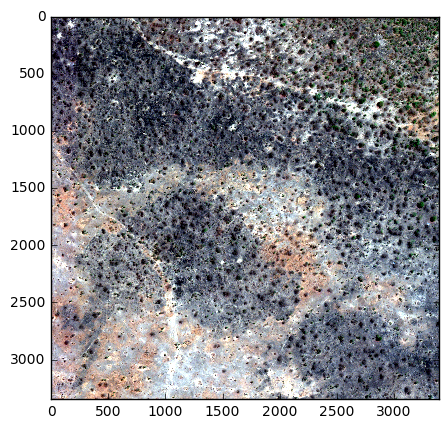

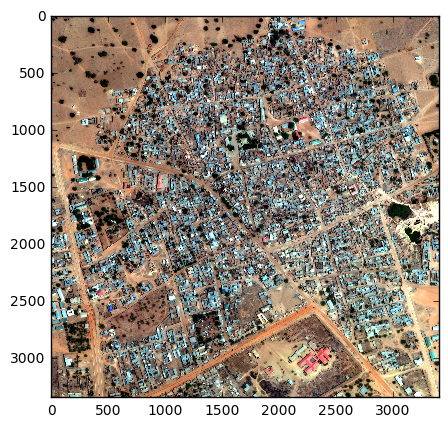

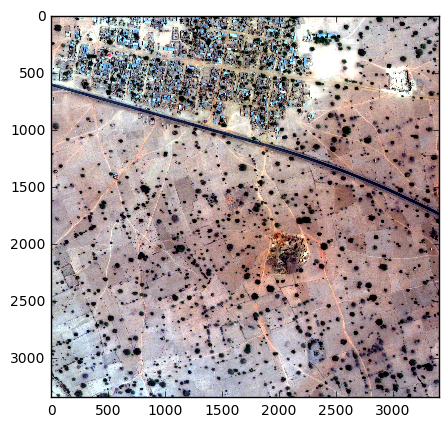

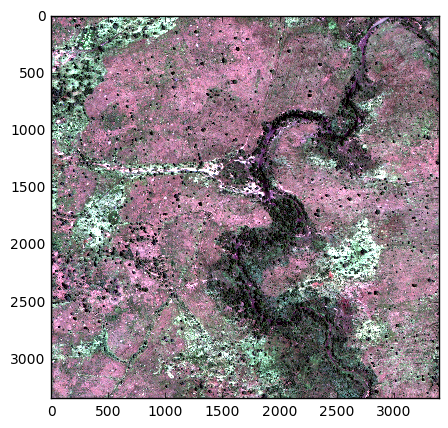

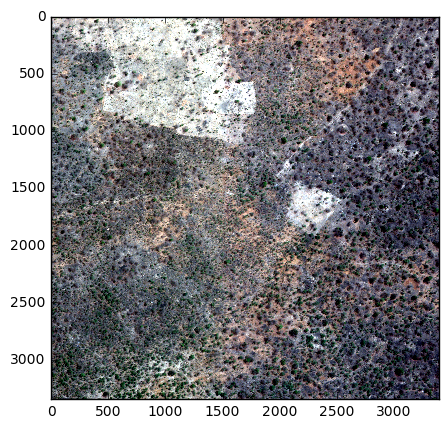

In [9]:
for image_id in train_image_ids [0:5]:
    show_image(image_id, image_size=(5,5), save_image=True)



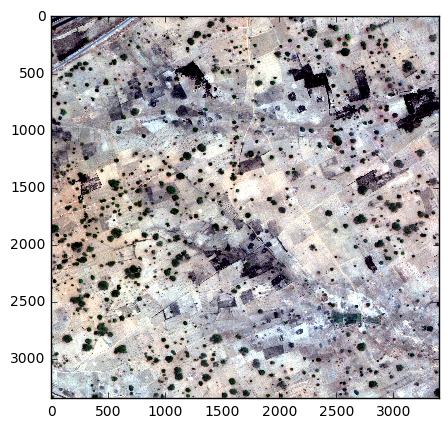

In [10]:
show_image('6140_3_2', image_size=(5,5))

In [11]:
train_image_ids

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'], dtype=object)

In [12]:
grid_sizes = pd.read_csv('satellite_image/grid_sizes.csv')
grid_sizes.columns = ['ImageId','Xmax','Ymin']

# Funtions to be used in the project

In [13]:
##To provide scalers that will be used to scale predicted polygons, convert pixels to coordinates   
## a,b = get_scalers ((3392,3321),0.875,-0.742),  return 3794.28605831 -4570.08125974  
def get_scalers(image_size, x_max, y_min):

    h,w = image_size  # they are flipped so that mask_for_polygons works correctly
    h = float(h)
    w = float(w)
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

In [14]:
## Convert polygons to mask,  copy from the other kernel
def mask_for_polygons(polygons, image_size):
    image_mask = np.zeros(image_size, np.uint8)   #3 dimensionspol.ext
    if not polygons:
        return image_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(image_mask, exteriors, 1)
    cv2.fillPoly(image_mask, interiors, 0)
    return image_mask

In [15]:
## Convert image to training data: X and y
def image_to_train(image_id, class_type, image_type='3'):
    # Get grid size: x_max and y_min
    x_max = grid_sizes[grid_sizes['ImageId']==image_id].Xmax.values[0]   
    # the reason we put 0, there might be some repeated values
    y_min = grid_sizes[grid_sizes['ImageId']==image_id].Ymin.values[0]

    # Load train poly with shapely
    train_polygons = shapely.wkt.loads(train_wkt[(train_wkt['ImageId']==image_id) & 
                                                (train_wkt['ClassType']==class_type)].MultipolygonWKT.values[0])

    # Read image with tiff
    if image_type =='3':
        image = tiff.imread('satellite_image/three_band/{}.tif'.format(image_id)).transpose([1, 2, 0])
    image_size = image.shape[:2]
    x_scaler, y_scaler = get_scalers(image_size, x_max, y_min)

    # Scale polygons
    train_polygons_scaled = shapely.affinity.scale(train_polygons,
                                                   xfact=x_scaler,
                                                   yfact=y_scaler,
                                                   origin=(0, 0, 0))

    train_mask = mask_for_polygons(train_polygons_scaled, image_size)
    if image_type =='3':
        X = image.reshape(-1, 3).astype(np.float32)
    y = train_mask.reshape(-1)
    return X, y, train_polygons

In [16]:
def image_to_test(image_id, image_type='3'):
    if image_type =='3':
        image = tiff.imread('satellite_image/three_band/{}.tif'.format(image_id)).transpose([1, 2, 0])
        image_shape = image.shape[0:2]
        X = image.reshape(-1, 3).astype(np.float32)
    return X, image_shape

In [17]:
image = tiff.imread('satellite_image/three_band/6010_0_1.tif')

In [18]:
image.shape

(3, 3349, 3396)

In [19]:
image = np.rollaxis(image,0,3)

In [20]:
image.shape

(3349, 3396, 3)

In [21]:
X = image.reshape(-1,3)

In [22]:
X.shape

(11373204, 3)

In [23]:
## Convert mask to polygons
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),   #1 type
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons



In [24]:
## Load/ merge/ convert training images into a single table for one certain class
def load_train_pixels(class_type, image_type='3',val_ids = None):
    start = time.time()
    image_ids = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
    train_x = np.array([])
    train_y = np.array([])
    if len(val_ids): ##preserved image ids for validation 
        for i in val_ids:
            image_ids.remove(i)
    print (len(image_ids),image_ids)
    print ("Loading data for class type %d" % (class_type))
    for image_id in image_ids:
        x, y, p = image_to_train(image_id, class_type, image_type)
        if len(train_x)==0:  ## initialize train_x
            train_x = x
        else:                ## append new image to train_x
            train_x = np.vstack((train_x,x))

        if len(train_y)==0:  ## initialize train_y with x
            train_y = y
        else:                ## append new data to train_y
            train_y = np.hstack((train_y,y))
    print ("Data loaded in %d seconds." % (time.time() - start), train_x.shape, train_y.shape)
    return train_x, train_y



In [25]:
def train_class(X, y, class_type, n_jobs=-1):
    pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log', n_jobs=n_jobs))
#     pipeline = make_pipeline(StandardScaler(), LogisticRegression(n_jobs=n_jobs))
    start = time.time()
    print('training...')
    pipeline.fit(X, y)
    print('training finished in %d seconds' % (time.time()-start))
    return pipeline

In [26]:
def train_pixel_models(class_types):
    clfs = dict()
    for class_type in class_types:
        print (class_type, class_types[class_type])
        train_x, train_y = load_train_pixels(class_type=class_type, image_type='3')    
        clfs[class_type] = train_class(train_x, train_y, class_type=class_type, n_jobs=-1)
    return clfs

In [27]:
def predict_class(image_id, clf, threshold = 0.05):
    ## Get test data
    test_x, test_image_shape = image_to_test(image_id)
    ## Make predictions
#     print ("Predicting....")
    pred_y = clf.predict_proba(test_x)[:, 1]

    ## Convert predictions to mask
    pred_mask = pred_y.reshape(test_image_shape)
#     pred_mask.shape

    ## Convert mask to polygonsx
    pred_mask = pred_mask >= threshold
    pred_polygons = mask_to_polygons(pred_mask)
    pred_poly_mask = mask_for_polygons(pred_polygons,test_image_shape)

    ## Scale polygons based on image's grid size
    test_x_max = grid_sizes[grid_sizes['ImageId']==image_id].Xmax.values[0]
    test_y_min = grid_sizes[grid_sizes['ImageId']==image_id].Ymin.values[0]    

    test_x_scaler, test_y_scaler = get_scalers(test_image_shape, test_x_max, test_y_min)

    scaled_pred_polygons = shapely.affinity.scale(
        pred_polygons, xfact=1 / test_x_scaler, yfact=1 / test_y_scaler, origin=(0, 0, 0))

    ## Convert polygons to WKT format
    pred_wkt = shapely.wkt.dumps(scaled_pred_polygons)
    # print (scaled_pred_polygons,shapely.wkt.dumps(scaled_pred_polygons))
    pred_polygons = shapely.wkt.loads(pred_wkt)
    return pred_y,pred_wkt, pred_polygons






In [28]:
def get_train_polygons(image_id,classes = CLASSES):
    train_wkt = pd.read_csv('satellite_image/train_wkt_v4.csv')
    WKTs = train_wkt[train_wkt.ImageId == image_id]
    polygonsList = {}
    for cType in classes.keys():
        polygonsList[cType] = wkt_loads(WKTs[WKTs.ClassType == cType].MultipolygonWKT.values[0])
    return polygonsList

In [29]:
def plot_polygons(polygonsList, image_id,figsize=(10, 10)):
    '''
    Plot descrates.PolygonPatch from list of polygons objs for each CLASS
    '''
    legend_patches = []
    fig, axArr = plt.subplots(figsize=figsize)
    ax = axArr
    for cType in polygonsList:
#         print('{} : {} \tcount = {}'.format(cType, CLASSES[cType], len(polygonsList[cType])))
        legend_patches.append(Patch(color=COLORS[cType],
                                    label='{} ({})'.format(CLASSES[cType], len(polygonsList[cType]))))
        for polygon in polygonsList[cType]:
            mpl_poly = PolygonPatch(polygon,
                                    color=COLORS[cType],
                                    lw=0,
                                    alpha=0.7,
                                    zorder=ZORDER[cType])
            ax.add_patch(mpl_poly)
    # ax.relim()
    ax.autoscale_view()
    ax.set_title('Objects')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(handles=legend_patches,
#            loc='upper left',
           bbox_to_anchor=(0.9, 1),
           bbox_transform=plt.gcf().transFigure,
           ncol=5,
           fontsize='x-small',
           title='Objects-' + image_id,
           # mode="expand",
           framealpha=0.3)
    #return legend_patches

# Give short names, sensible colors and zorders to object types

# Train one image one class for validation  (Road)

In [30]:
# train one image one class for validation
train_image_id = '6100_2_2'
val_image_id = '6100_2_3' 
class_type = 3    # train road first, good comparison

train_x, train_y, train_p = image_to_train(train_image_id, class_type, image_type='3')
                                          
val_x, val_y, val_p = image_to_train(val_image_id, class_type, image_type='3')

clf = make_pipeline(StandardScaler(), xgb.XGBClassifier(nthread=-1, learning_rate = 0.1, n_estimators=100))


start = time.time()
print('training...')
clf.fit(train_x, train_y )
print('training finished in %d seconds' % (time.time()-start))

pred_train_y = clf.predict_proba(train_x)[:,1]

pred_val_y = clf.predict_proba(val_x)[:,1]

## Show model accuracy. Here we are using AUC because single class is a skwed binary classfication where AUC works better.

print ("Training AUC: ", roc_auc_score(y_true=train_y, y_score=pred_train_y))
print ("Validation AUC:", roc_auc_score(y_true=val_y, y_score=pred_val_y))



training...
training finished in 82 seconds
('Training AUC: ', 0.97789653610715155)
('Validation AUC:', 0.72463246882707055)


Self-intersection at or near point 3252.0485436893205 1310.2912621359224
Self-intersection at or near point 3342.090909090909 398.81818181818181


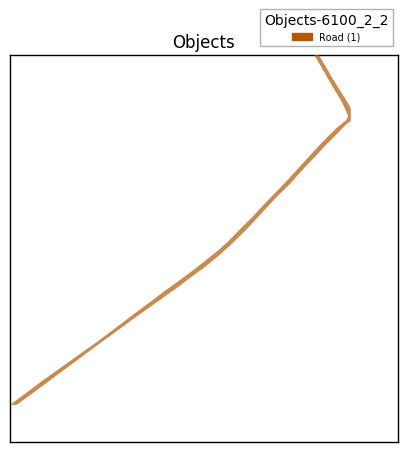

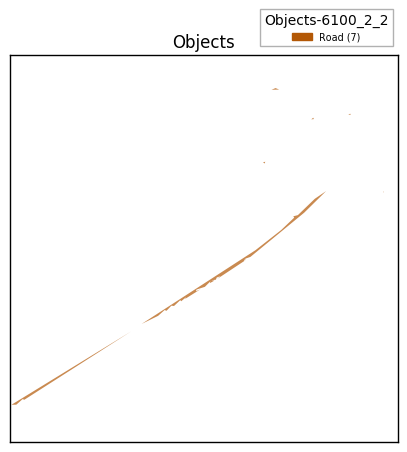

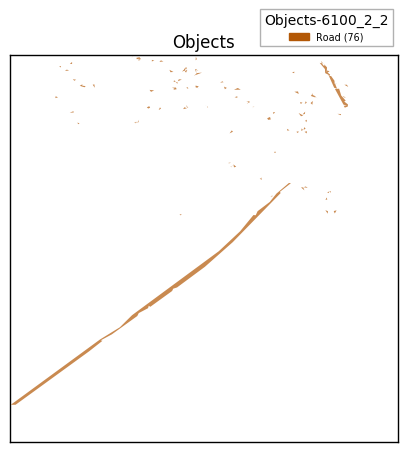

In [31]:
# Plot original training polygons
plot_polygons(image_id=train_image_id,polygonsList = {class_type:train_p}, figsize=(5,5))

# Larger threshold: 0.3
pred_train_y, pred_train_wkt, pred_train_p = predict_class(clf = clf, image_id = train_image_id, threshold=0.3)
# Plot predicted training polygons - it may overfit but here we just want to see how "well" the model learnt
plot_polygons(image_id=train_image_id,polygonsList = {class_type:pred_train_p},figsize=(5,5))

# Smaller threshold: 0.1
pred_train_y, pred_train_wkt, pred_train_p = predict_class(clf = clf, image_id = train_image_id, threshold=0.2)
plot_polygons(image_id=train_image_id,polygonsList = {class_type:pred_train_p},figsize=(5,5))



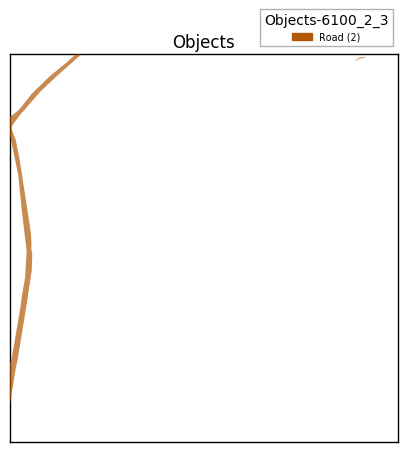

In [32]:
# check validation
plot_polygons(image_id=val_image_id,polygonsList = {class_type:val_p}, figsize=(5,5))

Self-intersection at or near point 2492.304347826087 843.39130434782612


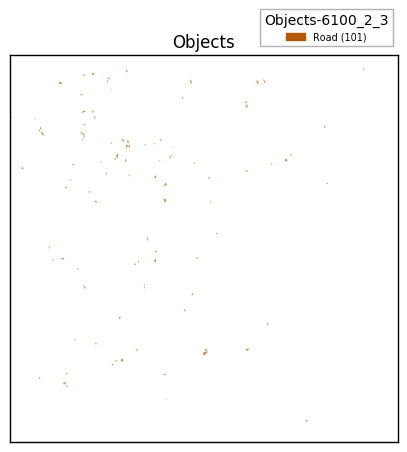

In [33]:
pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clf, image_id = val_image_id, threshold=0.25)

plot_polygons(image_id=val_image_id,polygonsList = {class_type:pred_val_p},figsize=(5,5))



Self-intersection at or near point 3324.7300613496932 149.65030674846625


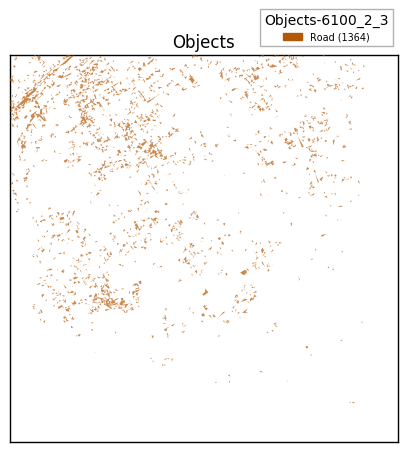

In [34]:
# Smaller threshold

pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clf, image_id = val_image_id, threshold=0.10)

plot_polygons(image_id=val_image_id,polygonsList = {class_type:pred_val_p},figsize=(5,5))

In [35]:
jaccard = pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area

In [36]:
print (jaccard)

0.0285839379748


# Train all classes with one image

In [37]:
train_x, train_y, train_p = image_to_train(train_image_id, class_type, image_type='3')
                                          
val_x, val_y, val_p = image_to_train(val_image_id, class_type, image_type='3')

clfs = dict()
for class_type in CLASSES:
    print (class_type, CLASSES[class_type])
    train_x, train_y, train_p = image_to_train(train_image_id, class_type, image_type='3')
    if train_y.sum() >0:
        pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
        #     pipeline = make_pipeline(StandardScaler(), LogisticRegression(n_jobs=n_jobs))
        start = time.time()
        print('training...')
        pipeline.fit(train_x, train_y)
        clfs[class_type] = pipeline
        print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))

(1, 'Buildings')
training...
training for class type 1 finishied in 78 seconds...
(2, 'Misc')
training...
training for class type 2 finishied in 81 seconds...
(3, 'Road')
training...
training for class type 3 finishied in 79 seconds...
(4, 'Track')
training...
training for class type 4 finishied in 78 seconds...
(5, 'Trees')
training...
training for class type 5 finishied in 79 seconds...
(6, 'Crops')
training...
training for class type 6 finishied in 79 seconds...
(7, 'Waterway')
training...
training for class type 7 finishied in 79 seconds...
(8, 'Standing water')
training...
training for class type 8 finishied in 78 seconds...
(9, 'Vehicle Large')
training...
training for class type 9 finishied in 76 seconds...
(10, 'Vehicle Small')
training...
training for class type 10 finishied in 78 seconds...


In [38]:
type(clfs)

dict

1


Self-intersection at or near point 3256.1021897810219 220.4014598540146


2


Self-intersection at or near point 3362.3372781065091 404.18934911242604


3


Self-intersection at or near point 3342.090909090909 398.81818181818181


4


Self-intersection at or near point 3024.8493150684931 1898.8356164383561


5


Self-intersection at or near point 3379.6139088729019 2626.3980815347722


6


Self-intersection at or near point 3326.8126801152739 1402.2161383285302


7


Self-intersection at or near point 1985.7567567567567 1183.3783783783783


8
9
10
('Training jaccard for class type 1', 0.48674354537308323)
('Training jaccard for class type 2', 0.020824267101714568)
('Training jaccard for class type 3', 0.5093417347188037)
('Training jaccard for class type 4', 0.1958783992569219)
('Training jaccard for class type 5', 0.3922894438280781)
('Training jaccard for class type 6', 0.5384633316488028)
('Training jaccard for class type 7', 0.5750268028097202)
('Training jaccard for class type 8', 0.0)
('Training jaccard for class type 9', 0.0)
('Training jaccard for class type 10', 0.0)
Overall training jaccard: 0.271857


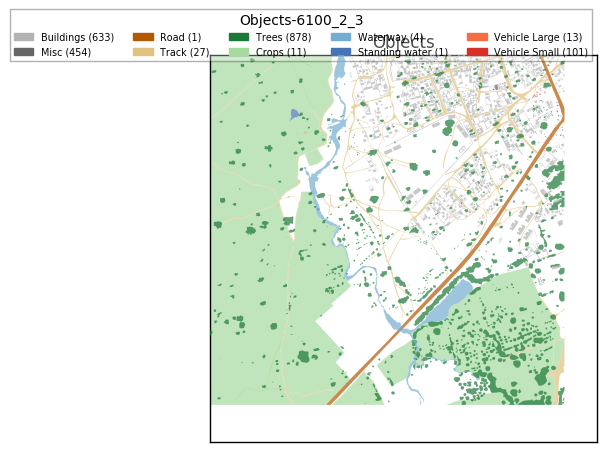

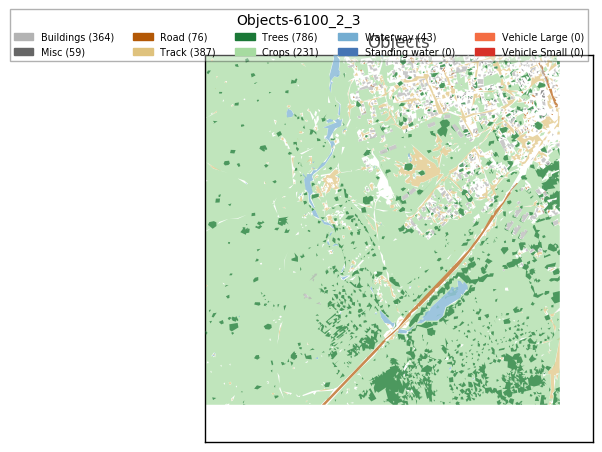

In [39]:
# Check one-to-one training result
preds = dict()

for clf in clfs:
    print (clf)
    pred_y, pred_wkt, pred_p = predict_class(train_image_id, clfs[clf], threshold = 0.2)
    preds[clf] = (pred_y, pred_wkt, pred_p)
    
pred_train_p = {}
for i in preds:
    pred_train_p[i] = preds[i][2]

## Training & validation Jaccards   

train_polygons = get_train_polygons(image_id=train_image_id)    
    
train_jaccards = []
for i in pred_train_p:
    jaccard = 0
    if pred_train_p.get(i,"MULTIPOLYGON EMPTY").union(train_polygons.get(i,"MULTIPOLYGON EMPTY")).area!=0:
        jaccard = pred_train_p.get(i,"MULTIPOLYGON EMPTY").intersection(train_polygons.get(i,"MULTIPOLYGON EMPTY")).area / pred_train_p.get(i,"MULTIPOLYGON EMPTY").union(train_polygons.get(i,"MULTIPOLYGON EMPTY")).area
    print('Training jaccard for class type %d' % (i), jaccard)
    train_jaccards.append(jaccard)   

print ("Overall training jaccard: %f" % (np.sum(train_jaccards)/10))
plot_polygons(image_id=val_image_id,polygonsList=train_polygons,figsize=(5,5))
plot_polygons(image_id=val_image_id,polygonsList=pred_train_p,figsize=(5,5))

1


Self-intersection at or near point 3369.646655231561 325.81475128644939


2


Self-intersection at or near point 3157.6973684210525 169.90789473684211


3


Self-intersection at or near point 2952.3096234309623 964.06694560669462


4


Self-intersection at or near point 3373.2631578947367 546.31578947368416


5


Self-intersection at or near point 3305.0687022900765 65.480916030534345


6


Self-intersection at or near point 3386.7563218390806 316.5735632183908


7


Self-intersection at or near point 3261.8000000000002 2914.1999999999998


8
9
10
('Validation jaccard for class type 1', 0.5328770038402786)
('Validation jaccard for class type 2', 0.03058631824744569)
('Validation jaccard for class type 3', 0.003133369421853795)
('Validation jaccard for class type 4', 0.21875314041508706)
('Validation jaccard for class type 5', 0.5081804027071385)
('Validation jaccard for class type 6', 0.0)
('Validation jaccard for class type 7', 0.0)
('Validation jaccard for class type 8', 0.0)
('Validation jaccard for class type 9', 0.0)
('Validation jaccard for class type 10', 0.0)
Overall Validation jaccard: 0.129353


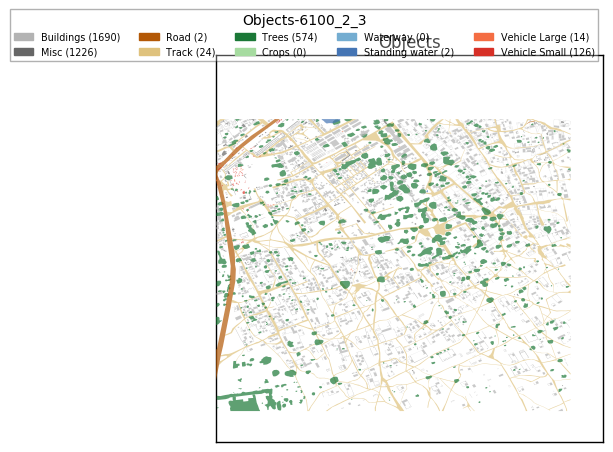

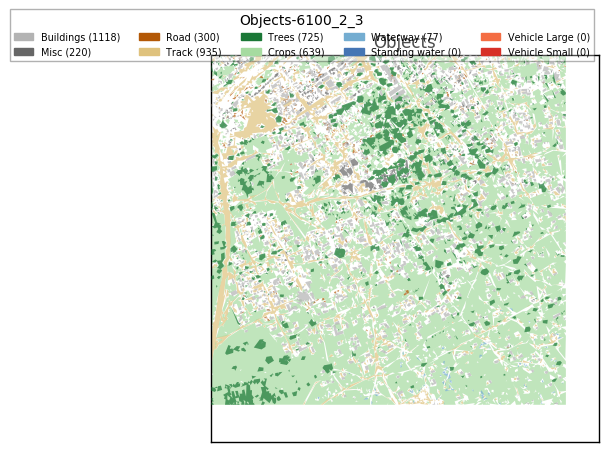

In [40]:
# Check one-to-one training result (difficult to distinguish tracks and roads)
preds_val = dict()

val_x, val_y, val_p = image_to_train(val_image_id, 5, image_type='3')

for clf in clfs:
    print (clf)
    pred_y, pred_wkt, pred_p = predict_class(val_image_id, clfs[clf], threshold = 0.2)
    preds_val[clf] = (pred_y, pred_wkt, pred_p)
    
pred_val_p = {}
for i in preds_val:
    pred_val_p[i] = preds_val[i][2]


val_polygons = get_train_polygons(image_id=val_image_id)    
    
val_jaccards = []
for i in pred_val_p:
    jaccard = 0
    if pred_val_p.get(i,"MULTIPOLYGON EMPTY").union(val_polygons.get(i,"MULTIPOLYGON EMPTY")).area!=0:
        jaccard = pred_val_p.get(i,"MULTIPOLYGON EMPTY").intersection(val_polygons.get(i,"MULTIPOLYGON EMPTY")).area / pred_val_p.get(i,"MULTIPOLYGON EMPTY").union(val_polygons.get(i,"MULTIPOLYGON EMPTY")).area
    print('Validation jaccard for class type %d' % (i), jaccard)
    val_jaccards.append(jaccard)  
print ("Overall Validation jaccard: %f" % (np.sum(val_jaccards)/10))   
plot_polygons(image_id=val_image_id,polygonsList=val_polygons,figsize=(5,5))
plot_polygons(image_id=val_image_id,polygonsList=pred_val_p,figsize=(5,5))

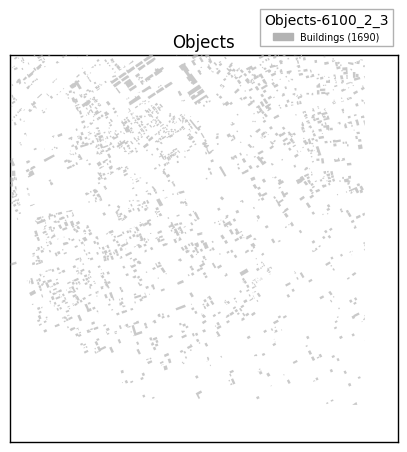

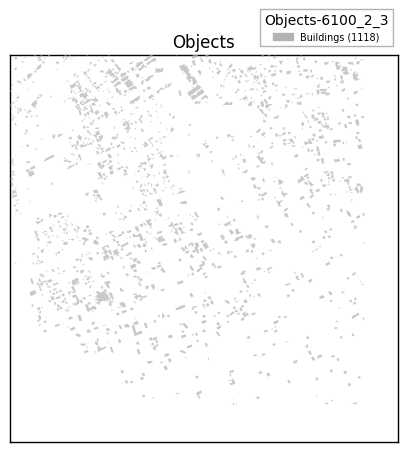

In [41]:
#Visulization for individual type
class_type = 1

plot_polygons(image_id=val_image_id,polygonsList={class_type: val_polygons[class_type]},figsize=(5,5))
plot_polygons(image_id=val_image_id,polygonsList={class_type: pred_val_p[class_type]},figsize=(5,5))

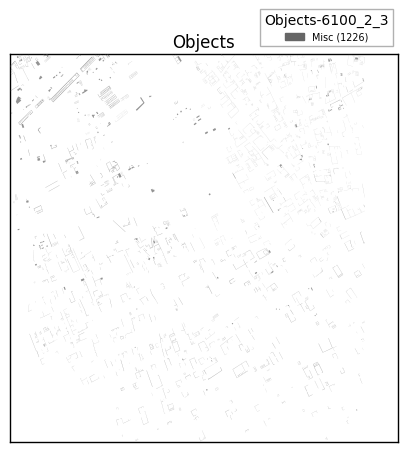

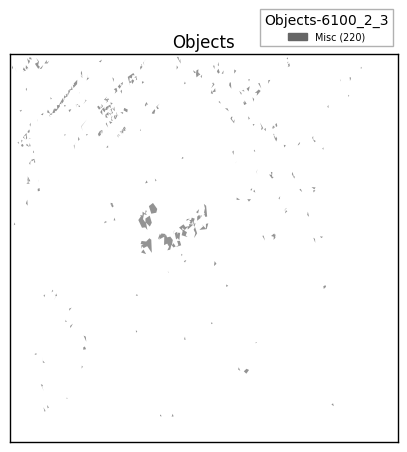

In [42]:
class_type = 2

plot_polygons(image_id=val_image_id,polygonsList={class_type: val_polygons[class_type]},figsize=(5,5))
plot_polygons(image_id=val_image_id,polygonsList={class_type: pred_val_p[class_type]},figsize=(5,5))

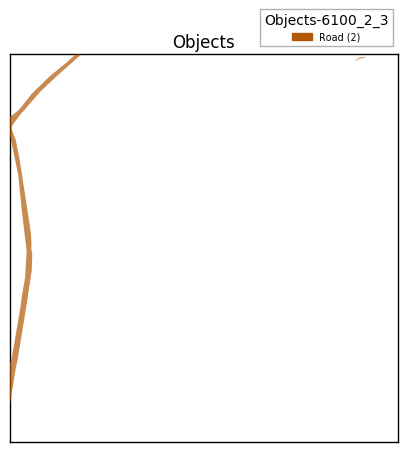

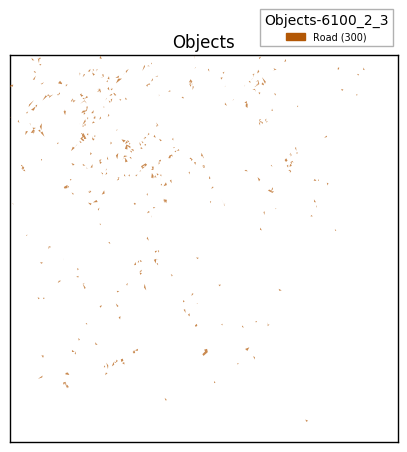

In [43]:
class_type = 3

plot_polygons(image_id=val_image_id,polygonsList={class_type: val_polygons[class_type]},figsize=(5,5))
plot_polygons(image_id=val_image_id,polygonsList={class_type: pred_val_p[class_type]},figsize=(5,5))

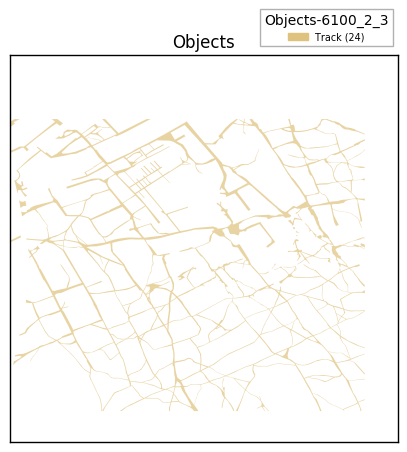

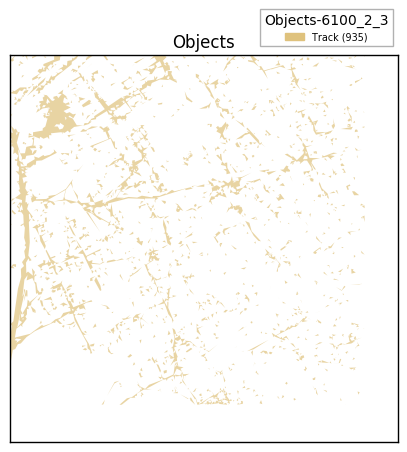

In [44]:
class_type = 4

plot_polygons(image_id=val_image_id,polygonsList={class_type: val_polygons[class_type]},figsize=(5,5))
plot_polygons(image_id=val_image_id,polygonsList={class_type: pred_val_p[class_type]},figsize=(5,5))

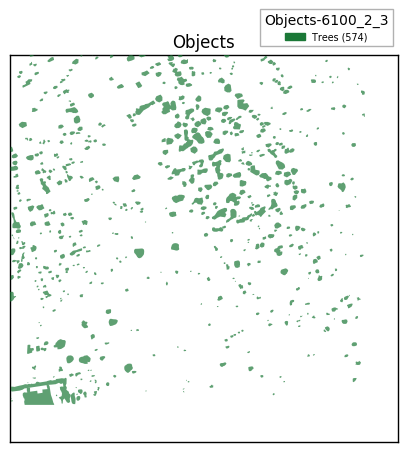

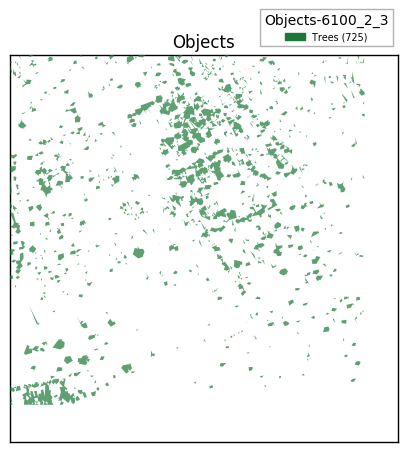

In [47]:
class_type = 5

plot_polygons(image_id=val_image_id,polygonsList={class_type: val_polygons[class_type]},figsize=(5,5))
plot_polygons(image_id=val_image_id,polygonsList={class_type: pred_val_p[class_type]},figsize=(5,5))

# Using U-net

In [201]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict



In [202]:
from __future__ import division

In [203]:
N_Cls = 10

DF = pd.read_csv('satellite_image/train_wkt_v4.csv')
GS = pd.read_csv('satellite_image/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv('satellite_image/sample_submission.csv')
ISZ = 160
smooth = 1e-12

In [204]:
print DF.columns
print GS.columns
print SB.columns

Index([u'ImageId', u'ClassType', u'MultipolygonWKT'], dtype='object')
Index([u'ImageId', u'Xmax', u'Ymin'], dtype='object')
Index([u'ImageId', u'ClassType', u'MultipolygonWKT'], dtype='object')


In [205]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [206]:
def _get_xmax_ymin(grid_sizes_panda, imageId):
    
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)

In [208]:
def _get_polygon_list(wkt_list_pandas, imageId, cType):
    
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList



In [209]:
def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

In [210]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

In [211]:
def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

In [212]:
def M(image_id):
   
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join('satellite_image', 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    
    return img

In [213]:
print 1/2

0.5


In [84]:
def stretch_n(bands, lower_percent=5, higher_percent=95):
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0
        b = 1
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

In [85]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    #sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [86]:
def stick_all_train():
    print ("let's stick all imgs together")
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print (len(ids))
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print (img.shape, id, np.amax(img), np.amin(img))
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print (np.amax(y), np.amin(y))

    np.save('satellite_image/x_trn_%d' % N_Cls, x)
    np.save('satellite_image/y_trn_%d' % N_Cls, y)

In [ ]:
def next_permutation(arr):
    # Find non-increasing suffix
    i = len(arr) - 1
    while i > 0 and arr[i - 1] >= arr[i]:
        i -= 1
    if i <= 0:
        return False
    
    # Find successor to pivot
    j = len(arr) - 1
    while arr[j] <= arr[i - 1]:
        j -= 1
    arr[i - 1], arr[j] = arr[j], arr[i - 1]
    
    # Reverse suffix
    arr[i : ] = arr[len(arr) - 1 : i - 1 : -1]
    return True


In [87]:
ids = sorted(DF.ImageId.unique())
print ids

['6010_1_2', '6010_4_2', '6010_4_4', '6040_1_0', '6040_1_3', '6040_2_2', '6040_4_4', '6060_2_3', '6070_2_3', '6090_2_0', '6100_1_3', '6100_2_2', '6100_2_3', '6110_1_2', '6110_3_1', '6110_4_0', '6120_2_0', '6120_2_2', '6140_1_2', '6140_3_1', '6150_2_3', '6160_2_1', '6170_0_4', '6170_2_4', '6170_4_1']


In [88]:
ids[1]

'6010_4_2'

In [89]:
A = M('6010_4_2')

In [90]:
A.shape

(837, 849, 8)

In [91]:
BB = stretch_n(A)

In [92]:
BB.shape

(837, 849, 8)

In [93]:
type(BB[3,3,3])

numpy.float32

In [94]:
os.getcwd()

'/Users/tianbaili/Desktop/data science/kaggle'

In [95]:
def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []
    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print (x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
    return x, y

In [96]:
def make_val():
    print ("let's pick some samples for validation")
    img = np.load('satellite_image/x_trn_%d.npy' % N_Cls)
    msk = np.load('satellite_image/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)

    np.save('satellite_image/x_tmp_%d' % N_Cls, x)
    np.save('satellite_image/y_tmp_%d' % N_Cls, y)

In [97]:
def calc_jacc(model):
    img = np.load('satellite_image/x_tmp_%d.npy' % N_Cls)
    msk = np.load('satellite_image/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print (i, m, b_tr)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs

In [98]:
def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [99]:
def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min



# U-NET model

In [100]:
def get_unet():
    inputs = Input((8, ISZ, ISZ))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',init='he_normal')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)
    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu',f border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [101]:
def train_net():
    print ("start train net")
    x_val, y_val = np.load('satellite_image/x_tmp_%d.npy' % N_Cls), np.load('satellite_image/y_tmp_%d.npy' % N_Cls)
    img = np.load('satellite_image/x_trn_%d.npy' % N_Cls)
    msk = np.load('satellite_image/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)

    model = get_unet()
    model.load_weights('satellite_image/unet_10_jk0.7878')
    model_checkpoint = ModelCheckpoint('satellite_image/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=3, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print ('val jk', score)
        model.save_weights('satellite_image/unet_10_jk%.4f' % score)

    return model

In [102]:
def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]

In [114]:
def predict_test(model, trs):
    print ("predict test")
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save('satellite_image/output/msk/10_%s' % id, msk)
        if i % 100 == 0: 
            print (i, id)


def make_submit():
    print ("make submission file")
    df = pd.read_csv(os.path.join('satellite_image', 'sample_submission.csv'))
    print (df.head())
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load('satellite_image/output1_8/msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: 
            print (idx)
    print (df.head())
    df.to_csv('satellite_image/output1_8/unet1.csv', index=False)
    
    
def check_predict(id='6120_2_3'):
    model = get_unet()
    model.load_weights('satellite_image/unet_10_jk0.7448')

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure()
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

In [107]:
stick_all_train()

let's stick all imgs together
25
((837, 849, 8), '6010_1_2', 1.0, 0.0)
((837, 849, 8), '6010_4_2', 1.0, 0.0)
((837, 848, 8), '6010_4_4', 1.0, 0.0)
((837, 848, 8), '6040_1_0', 1.0, 0.0)
((837, 848, 8), '6040_1_3', 1.0, 0.0)
((837, 848, 8), '6040_2_2', 1.0, 0.0)
((837, 846, 8), '6040_4_4', 1.0, 0.0)
((837, 851, 8), '6060_2_3', 1.0, 0.0)
((838, 835, 8), '6070_2_3', 1.0, 0.0)
((837, 848, 8), '6090_2_0', 1.0, 0.0)
((837, 848, 8), '6100_1_3', 1.0, 0.0)
((837, 848, 8), '6100_2_2', 1.0, 0.0)
((837, 848, 8), '6100_2_3', 1.0, 0.0)
((837, 849, 8), '6110_1_2', 1.0, 0.0)
((837, 849, 8), '6110_3_1', 1.0, 0.0)
((837, 849, 8), '6110_4_0', 1.0, 0.0)
((837, 851, 8), '6120_2_0', 1.0, 0.0)
((837, 851, 8), '6120_2_2', 1.0, 0.0)
((837, 849, 8), '6140_1_2', 1.0, 0.0)
((837, 849, 8), '6140_3_1', 1.0, 0.0)
((837, 851, 8), '6150_2_3', 1.0, 0.0)
((837, 848, 8), '6160_2_1', 1.0, 0.0)
((837, 848, 8), '6170_0_4', 1.0, 0.0)
((837, 848, 8), '6170_2_4', 1.0, 0.0)
((837, 848, 8), '6170_4_1', 1.0, 0.0)
(1.0, 0.0)


In [108]:
make_val()

let's pick some samples for validation
((1007, 8, 160, 160), (1007, 10, 160, 160), 1.0, -1.0, 1.0, 0.0)


In [110]:
print 1/2

0.5


In [116]:
make_submit()

Self-intersection at or near point 617.05980066445181 673.92358803986713


make submission file
    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
0


Self-intersection at or near point 507.08695652173913 557
Self-intersection at or near point 815.21897810218979 649.43065693430663
Self-intersection at or near point 250.03883495145632 321.45631067961165
Self-intersection at or near point 447 595.14285714285711
Self-intersection at or near point 12.9375 779
Self-intersection at or near point 401.3307086614173 605.41374373657834
Self-intersection at or near point 195.34883720930233 215.6046511627907
Self-intersection at or near point 773.94074074074069 556.67407407407404
Self-intersection at or near point 792.2658227848101 624.08860759493666
Self-intersection at or near point 657.17647058823525 745.17647058823525
Self-intersection at or near point 53.085227272727273 174.86363636363637
Self-intersection at or near point 704.16666666666663 188.58333333333334
Self-intersection at or near point 842.03875968992247 97.023255813953483
Self-intersection at or near point 601.97297297297303 254.83783783783784
Self-intersection at or near point 46

100


Self-intersection at or near point 832.51336898395721 58.802139037433157
Self-intersection at or near point 538.69000000000005 690.54999999999995
Self-intersection at or near point 672.10679611650482 86.048543689320383
Self-intersection at or near point 840.52380952380952 621.95238095238096
Self-intersection at or near point 816.97297297297303 693.59459459459458
Self-intersection at or near point 714.5130970724191 833.5462249614792
Self-intersection at or near point 431.79710144927537 767.82608695652175
Self-intersection at or near point 800.76744186046517 77.883720930232556
Self-intersection at or near point 797 198.28571428571428
Self-intersection at or near point 159 367
Self-intersection at or near point 278.60362694300517 293.94170984455957
Self-intersection at or near point 347.58426966292137 788.78089887640454
Ring Self-intersection at or near point 833 380
Self-intersection at or near point 366.24840764331208 305.56050955414014
Self-intersection at or near point 305.52631578947

200


Self-intersection at or near point 692.05084745762713 452.61016949152543
Self-intersection at or near point 23 524.66666666666663
Self-intersection at or near point 819.00527704485489 754.91556728232194
Self-intersection at or near point 149.34999999999999 700.51428571428573
Self-intersection at or near point 843.51428571428573 342.85714285714283
Self-intersection at or near point 772.53642384105956 572.81456953642385
Self-intersection at or near point 844.68516649848641 298.38748738647831
Self-intersection at or near point 757.18410041841003 735.98744769874475
Self-intersection at or near point 831.4406779661017 659.66101694915255
Self-intersection at or near point 845.68571428571431 776.15714285714284
Self-intersection at or near point 363.82499999999999 12.800000000000001
Self-intersection at or near point 188.09774436090225 288.75187969924809
Self-intersection at or near point 525.93220338983053 777.71186440677968
Self-intersection at or near point 831.94285714285718 86.11428571428

300


Self-intersection at or near point 786.12422360248445 18.198757763975156
Self-intersection at or near point 199.4140625 833.296875
Self-intersection at or near point 779.16666666666663 468.16666666666669
Self-intersection at or near point 794.6640625 616.5625
Self-intersection at or near point 799.03629257398097 834.41931881630376
Self-intersection at or near point 239 835
Self-intersection at or near point 135.39179954441914 156.33485193621868
Self-intersection at or near point 758.98630136986299 49.958904109589042
Self-intersection at or near point 828.99352750809066 160.06472491909386
Self-intersection at or near point 766.65405405405409 125.84324324324324
Self-intersection at or near point 379.28767123287673 660.67123287671234
Self-intersection at or near point 831.47692307692307 225.73846153846154
Self-intersection at or near point 833 38
Self-intersection at or near point 14.918032786885245 678.03278688524586
Self-intersection at or near point 642 183
Self-intersection at or near

400


Self-intersection at or near point 787.24301675977654 144.13407821229049
Self-intersection at or near point 263.03342618384403 419.15041782729804
Self-intersection at or near point 660.66666666666663 424.66666666666669
Self-intersection at or near point 527.53846153846155 364.23076923076923
Self-intersection at or near point 791.75 317.25
Self-intersection at or near point 783.51724137931035 116.62068965517241
Self-intersection at or near point 809.18181818181813 317.77272727272725
Self-intersection at or near point 844.8478260869565 804.95652173913038
Self-intersection at or near point 611.5 41
Self-intersection at or near point 843.35514018691583 214.61682242990653
Self-intersection at or near point 844.41361256544508 775.50261780104711
Self-intersection at or near point 629.26855123674909 692.27561837455835
Self-intersection at or near point 548.58823529411768 239.41176470588235
Self-intersection at or near point 846.23826458036979 534.16927453769563
Self-intersection at or near poi

500


Self-intersection at or near point 623.6880733944954 9.6697247706422012
Self-intersection at or near point 550.56756756756761 407.45945945945948
Self-intersection at or near point 774.95533498759301 159.7468982630273
Self-intersection at or near point 593.6062992125984 315.13385826771656
Self-intersection at or near point 842.62264150943395 358.85849056603774
Self-intersection at or near point 58.789473684210527 189.78947368421052
Self-intersection at or near point 374.1219512195122 827.67479674796743
Self-intersection at or near point 262.44897959183675 365.81632653061223
Self-intersection at or near point 799.26229508196718 505.8360655737705
Self-intersection at or near point 126.39222614840989 276.11130742049471
Self-intersection at or near point 754 709.39999999999998
Self-intersection at or near point 118.42857142857143 500.8095238095238
Self-intersection at or near point 739.39506172839504 685.44444444444446
Self-intersection at or near point 372.81818181818181 112.18181818181819

600


Self-intersection at or near point 615.34188034188037 60.752136752136749
Self-intersection at or near point 159 827
Self-intersection at or near point 776.30927835051546 17.123711340206185
Self-intersection at or near point 717 835
Self-intersection at or near point 803.33333333333337 480.66666666666669
Self-intersection at or near point 595.4904437965663 833.16974408811143
Self-intersection at or near point 697 336.75
Self-intersection at or near point 754 833.19047619047615
Self-intersection at or near point 777.06041335453097 84.461049284578692
Self-intersection at or near point 818 835
Self-intersection at or near point 417.70842332613393 544.26349892008636
Ring Self-intersection at or near point 778 754
Self-intersection at or near point 442.38297872340428 247.82978723404256
Self-intersection at or near point 795.49086161879893 217.46475195822455
Self-intersection at or near point 676.29496402877703 311.10071942446041
Self-intersection at or near point 714.11709286675637 800.05518

700


Self-intersection at or near point 827.79999999999995 791.5
Self-intersection at or near point 598.29032258064512 81.645161290322577
Self-intersection at or near point 517.4434782608696 40.904347826086955
Self-intersection at or near point 799 731
Ring Self-intersection at or near point 100 411
Self-intersection at or near point 232.98019801980197 358.34653465346537
Self-intersection at or near point 78.163410301953817 769.93783303730015
Self-intersection at or near point 769.94915254237287 65.264406779661016
Self-intersection at or near point 202.26244343891403 131.62895927601809
Self-intersection at or near point 232.9367088607595 87.265822784810126
Self-intersection at or near point 644.57324840764329 443.484076433121
Self-intersection at or near point 798 554
Self-intersection at or near point 82.903225806451616 425.80645161290323
Self-intersection at or near point 704.64285714285711 194.67857142857142
Self-intersection at or near point 378 250
Self-intersection at or near point 58

800


Self-intersection at or near point 787.14285714285711 257.85714285714283
Ring Self-intersection at or near point 656 111
Self-intersection at or near point 630.64705882352939 424
Self-intersection at or near point 467.66336633663366 63.257425742574256
Self-intersection at or near point 77.285714285714292 225.42857142857142
Self-intersection at or near point 508.95327102803736 342.10280373831773
Ring Self-intersection at or near point 647 319
Self-intersection at or near point 327.83582089552237 700.14925373134326
Self-intersection at or near point 845.39285714285711 338.17857142857144
Self-intersection at or near point 727.60869565217388 240.91304347826087
Self-intersection at or near point 30.5625 15.28125
Self-intersection at or near point 518.12448132780082 659.14107883817428
Self-intersection at or near point 300.58173076923077 709.05288461538464
Self-intersection at or near point 460.27710843373495 317.71084337349396
Self-intersection at or near point 617.63157894736844 314.105263

900


Self-intersection at or near point 769 679
Ring Self-intersection at or near point 159 835
Self-intersection at or near point 456.73563218390802 637.52183908045981
Self-intersection at or near point 845.89473684210532 78.89473684210526
Self-intersection at or near point 846.46341463414637 125.73170731707317
Self-intersection at or near point 845.19024390243908 262.93170731707318
Self-intersection at or near point 628.5 800.57692307692309
Self-intersection at or near point 740.81341107871719 832.83090379008752
Self-intersection at or near point 514 62.444444444444443
Self-intersection at or near point 700.9677419354839 389.12903225806451
Self-intersection at or near point 828.24719101123594 580.39325842696633
Ring Self-intersection at or near point 640 647
Self-intersection at or near point 609.5 602.5
Self-intersection at or near point 533.47058823529414 7.7058823529411766
Ring Self-intersection at or near point 372 835
Self-intersection at or near point 632.27234042553187 334.35319148

1000


Self-intersection at or near point 294.9557945041816 831.89486260453998
Ring Self-intersection at or near point 299 639
Self-intersection at or near point 758.79310344827582 633.37931034482756
Self-intersection at or near point 769.51999999999998 244.45500000000001
Self-intersection at or near point 842.74418604651157 50.302325581395351
Self-intersection at or near point 816 282
Self-intersection at or near point 269.11787072243345 270.77186311787074
Self-intersection at or near point 776.52631578947364 260.68421052631578
Self-intersection at or near point 667.25531914893622 413.02127659574467
Self-intersection at or near point 320.55609051516609 275.05296100144437
Self-intersection at or near point 728 717
Self-intersection at or near point 589.21621621621625 364.05405405405406
Self-intersection at or near point 846.69491525423734 71.644067796610173
Self-intersection at or near point 659.34042553191489 741.23404255319144
Self-intersection at or near point 517.95906432748541 444.953216

1100


Self-intersection at or near point 3.3779904306220097 454.53588516746413
Self-intersection at or near point 560.14285714285711 475.28571428571428
Self-intersection at or near point 715.14705882352939 229.38235294117646
Self-intersection at or near point 344.61111111111109 270.61111111111109
Self-intersection at or near point 583.20000000000005 120.2
Self-intersection at or near point 627.40625 235.8125
Self-intersection at or near point 673.55172413793105 341.93103448275861
Self-intersection at or near point 477 82
Self-intersection at or near point 801.90909090909088 52.909090909090907
Self-intersection at or near point 140.5934065934066 784.17582417582423
Self-intersection at or near point 640.03327495621716 163.29772329246936
Self-intersection at or near point 647.88607594936707 789.43037974683546
Self-intersection at or near point 165.2550724637681 76.185507246376815
Self-intersection at or near point 597.4375 108.375
Self-intersection at or near point 339.71232876712327 374.328767

1200


Self-intersection at or near point 480.25 188.5
Self-intersection at or near point 26.132450331125828 284.28476821192055
Self-intersection at or near point 812.68292682926824 826.19512195121956
Self-intersection at or near point 824.0625 236.75
Self-intersection at or near point 777.54330708661416 637.27559055118115
Self-intersection at or near point 33.248908296943235 8.2314410480349345
Self-intersection at or near point 626.85416666666663 187.20833333333334
Self-intersection at or near point 353.00884955752213 750.90265486725662
Self-intersection at or near point 846.34643734643737 188.62162162162161
Self-intersection at or near point 842.12307692307695 688.42461538461544
Self-intersection at or near point 155 35.714285714285715
Self-intersection at or near point 628.44000000000005 820.96000000000004
Self-intersection at or near point 630.67741935483866 716.9677419354839
Self-intersection at or near point 752 818.96296296296293
Self-intersection at or near point 8.6056338028169019 24

1300


Ring Self-intersection at or near point 505 479
Self-intersection at or near point 451.23076923076923 833.30769230769226
Self-intersection at or near point 590.03703703703707 200.92592592592592
Self-intersection at or near point 255.41078838174275 834.45228215767634
Self-intersection at or near point 844.10909090909092 226.21818181818182
Self-intersection at or near point 755.0523560209424 365.63350785340316
Self-intersection at or near point 810.05494505494505 234.86813186813185
Self-intersection at or near point 604 713.5
Self-intersection at or near point 583.77323420074345 799.55390334572496
Self-intersection at or near point 787 178.54166666666666
Self-intersection at or near point 764.83236994219658 281.16184971098266
Self-intersection at or near point 317.84615384615387 508.69230769230768
Self-intersection at or near point 836.27272727272725 544
Self-intersection at or near point 554.44660194174753 43.834951456310677
Self-intersection at or near point 683.03414634146338 386.5560

1400


Self-intersection at or near point 768.56976744186045 245.95348837209303
Self-intersection at or near point 639.31831831831835 366.49849849849852
Self-intersection at or near point 785.60606060606062 214.15151515151516
Self-intersection at or near point 481.24555160142347 141.02491103202846
Self-intersection at or near point 777.90588235294115 166.8235294117647
Self-intersection at or near point 76 272
Self-intersection at or near point 352 406.86956521739131
Self-intersection at or near point 758.64606741573039 116.0561797752809
Ring Self-intersection at or near point 849 640
Self-intersection at or near point 207.47058823529412 119.88235294117646
Self-intersection at or near point 169.80000000000001 405.60000000000002
Self-intersection at or near point 529 20.692307692307693
Self-intersection at or near point 843.70000000000005 832.69000000000005
Self-intersection at or near point 673.14634146341461 555.80487804878044
Self-intersection at or near point 322.60000000000002 639
Self-int

1500


Self-intersection at or near point 572.96577946768059 73.057034220532316
Self-intersection at or near point 832.29339477726569 291.31797235023043
Self-intersection at or near point 481.17857142857144 769.41071428571433
Self-intersection at or near point 828.14999999999998 387.85000000000002
Ring Self-intersection at or near point 518 836
Self-intersection at or near point 622.74647887323943 830.25352112676057
Self-intersection at or near point 829.71493212669679 491.12217194570138
Ring Self-intersection at or near point 624 836
Self-intersection at or near point 828.37209302325584 561.04651162790697
Self-intersection at or near point 523.74193548387098 663.0322580645161
Self-intersection at or near point 849 495
Self-intersection at or near point 162.47368421052633 831.57894736842104
Self-intersection at or near point 750.71875 209.5625
Self-intersection at or near point 837.31343283582089 444.35820895522386
Self-intersection at or near point 742.77867203219319 282.49698189134807
Self-

1600


Self-intersection at or near point 60.444444444444443 463
Self-intersection at or near point 309.76763485477176 722.49377593360998
Self-intersection at or near point 630.05405405405406 389.7837837837838
Self-intersection at or near point 539.91907514450872 357.80346820809251
Self-intersection at or near point 87.709677419354833 268.48387096774195
Self-intersection at or near point 312.7560975609756 214.28455284552845
Self-intersection at or near point 749.32475884244377 817.71704180064307
Self-intersection at or near point 808.68253968253964 683.38095238095241
Self-intersection at or near point 745.02531645569616 117.53164556962025
Self-intersection at or near point 100 127
Self-intersection at or near point 817 717.42857142857144
Self-intersection at or near point 817.11702127659578 524.85638297872345
Self-intersection at or near point 471.15789473684208 146.57894736842104
Self-intersection at or near point 323.48672566371681 799.04424778761063
Self-intersection at or near point 370.3

1700


Self-intersection at or near point 140.57142857142858 739.42857142857144
Self-intersection at or near point 5.9357798165137616 823.71559633027528
Self-intersection at or near point 708.03118908382066 294.05847953216374
Self-intersection at or near point 698.53846153846155 722.53846153846155
Self-intersection at or near point 663.44776119402979 462.26119402985074
Self-intersection at or near point 484.25433526011562 83.104046242774572
Self-intersection at or near point 711.67586206896556 146.08275862068965
Self-intersection at or near point 458.11320754716979 5.4905660377358494
Self-intersection at or near point 546.14999999999998 760.29999999999995
Self-intersection at or near point 846.33888888888885 115.52777777777777
Self-intersection at or near point 746.15865384615381 84.836538461538467
Self-intersection at or near point 733.11475409836066 650.36065573770497
Self-intersection at or near point 678.04807692307691 327.26923076923077
Self-intersection at or near point 477.103773584905

1800


Self-intersection at or near point 832.88326848249028 658.92217898832689
Self-intersection at or near point 822.16788321167883 16.759124087591243
Self-intersection at or near point 829.53658536585363 388.26829268292681
Self-intersection at or near point 395.90697674418607 730.11627906976742
Self-intersection at or near point 475.53719008264466 277.59504132231405
Self-intersection at or near point 760 699.52941176470586
Self-intersection at or near point 777 38
Self-intersection at or near point 676.32967032967031 539.69230769230774
Self-intersection at or near point 845.40166204986144 749.63434903047096
Self-intersection at or near point 816.46308724832215 133.24832214765101
Self-intersection at or near point 548.72727272727275 208.72727272727272
Self-intersection at or near point 433.58441558441558 828.81818181818187
Self-intersection at or near point 723 528
Self-intersection at or near point 835.88607594936707 557.08860759493666
Self-intersection at or near point 24.566929133858267 

1900


Self-intersection at or near point 293.375 342.625
Self-intersection at or near point 422.21951219512198 67.243902439024396
Self-intersection at or near point 235.70149253731344 75.447761194029852
Self-intersection at or near point 387.875 38.625
Self-intersection at or near point 836.10526315789468 211.78947368421052
Self-intersection at or near point 820.0526315789474 152.36842105263159
Self-intersection at or near point 225.74093264248705 827.68911917098444
Self-intersection at or near point 316.65921787709499 561.59776536312847
Self-intersection at or near point 6.0256410256410255 217
Self-intersection at or near point 628.83636363636367 110.13636363636364
Self-intersection at or near point 702.89908256880733 513.40366972477068
Self-intersection at or near point 201 364
Self-intersection at or near point 351.79411764705884 824.97058823529414
Self-intersection at or near point 652.31481481481478 46.629629629629626
Self-intersection at or near point 276.7837837837838 61.4594594594594

2000


Self-intersection at or near point 247.77777777777777 549.77777777777783
Self-intersection at or near point 796.86096256684493 26.160427807486631
Self-intersection at or near point 639.97755960729307 203.99018232819074
Self-intersection at or near point 771.20799999999997 678.24800000000005
Self-intersection at or near point 649.12213740458014 292.19083969465646
Self-intersection at or near point 843.41860465116281 165.69767441860466
Self-intersection at or near point 843.33009708737859 492.44336569579286
Self-intersection at or near point 539.18309859154931 112.94366197183099
Self-intersection at or near point 835.80769230769226 305.19230769230768
Self-intersection at or near point 630.32000000000005 179.03999999999999
Self-intersection at or near point 3.9179004037685061 823.61372812920592
Self-intersection at or near point 798.58227848101262 604.30379746835445
Self-intersection at or near point 687.17647058823525 471.05882352941177
Self-intersection at or near point 822.952380952380

2100


Self-intersection at or near point 828.64999999999998 350.25
Self-intersection at or near point 458.96153846153845 768.65384615384619
Self-intersection at or near point 666.80952380952385 553.33333333333337
Ring Self-intersection at or near point 429 320
Self-intersection at or near point 519 835
Self-intersection at or near point 577.20487804878053 43.926829268292686
Self-intersection at or near point 639.83636363636367 789
Self-intersection at or near point 478.83710407239818 830.59276018099547
Self-intersection at or near point 756.89473684210532 92.10526315789474
Self-intersection at or near point 775.24761904761908 423.1142857142857
Self-intersection at or near point 394.59259259259261 677.77777777777783
Self-intersection at or near point 329.81818181818181 694.81818181818187
Self-intersection at or near point 702.42446043165467 579.87050359712225
Self-intersection at or near point 829.62886597938143 14.463917525773196
Self-intersection at or near point 635.70769230769235 678.6153

2200


Self-intersection at or near point 830.87272727272727 475.9818181818182
Ring Self-intersection at or near point 688 836
Self-intersection at or near point 825.79999999999995 411.39999999999998
Self-intersection at or near point 787.63855421686742 472.08433734939757
Self-intersection at or near point 373.0625 829.8125
Self-intersection at or near point 548.85454545454547 34.436363636363637
Self-intersection at or near point 397.07499999999999 89.700000000000003
Ring Self-intersection at or near point 640 488
Self-intersection at or near point 811.17333333333329 162.13333333333333
Self-intersection at or near point 135.02564102564102 819.20512820512818
Self-intersection at or near point 779.80645161290317 543.67741935483866
Self-intersection at or near point 823.26548672566366 503.64601769911502
Self-intersection at or near point 758.36842105263156 416
Self-intersection at or near point 106.64 371.95999999999998
Self-intersection at or near point 795.18867924528297 186.0566037735849
Self

2300


Self-intersection at or near point 649.30622009569379 781.86602870813397
Self-intersection at or near point 582.61904761904759 32.38095238095238
Self-intersection at or near point 844.95000000000005 429.89999999999998
Self-intersection at or near point 749.29496402877703 296.0503597122302
Self-intersection at or near point 788.85294117647061 799.30882352941171
Self-intersection at or near point 459.5742145178765 160.91874322860238
Self-intersection at or near point 525.31818181818187 282.72727272727275
Self-intersection at or near point 797.76354679802955 442.6502463054187
Self-intersection at or near point 152.61538461538461 256.07692307692309
Self-intersection at or near point 277.55882352941177 291
Self-intersection at or near point 585.84269662921349 786.98876404494376
Self-intersection at or near point 187.9017199017199 371.88943488943488
Self-intersection at or near point 86 449.33333333333331
Ring Self-intersection at or near point 141 436
Self-intersection at or near point 638.

2400


Self-intersection at or near point 784.97196261682245 43.953271028037385
Self-intersection at or near point 844.33516483516485 252.02747252747253
Self-intersection at or near point 645.95041322314046 370.44628099173553
Self-intersection at or near point 742.9973808276585 830.09062336301724
Self-intersection at or near point 720.16666666666663 70.625
Self-intersection at or near point 290.65934065934067 559.1868131868132
Self-intersection at or near point 798.70638297872335 427.54468085106384
Self-intersection at or near point 843.04761904761904 75.761904761904759
Self-intersection at or near point 828.89887640449433 30.674157303370787
Self-intersection at or near point 799.41224489795923 619.47755102040821
Self-intersection at or near point 703.42477876106193 239.05309734513276
Self-intersection at or near point 631.30379746835445 316.58227848101268
Self-intersection at or near point 836.86301369863008 714.1232876712329
Self-intersection at or near point 813.00819672131149 333.90983606

2500


Ring Self-intersection at or near point 635 833
Self-intersection at or near point 165.38461538461539 370.61538461538464
Self-intersection at or near point 417.25423728813558 817.53389830508479
Self-intersection at or near point 831.05714285714282 565.94285714285718
Self-intersection at or near point 216.27014218009478 832.58293838862562
Self-intersection at or near point 174.19999999999999 76.150000000000006
Self-intersection at or near point 177.53231939163499 12.368821292775666
Self-intersection at or near point 503.90393013100436 301.63318777292574
Self-intersection at or near point 778.35598705501616 311.50161812297733
Self-intersection at or near point 207.05263157894737 373
Self-intersection at or near point 264.11111111111109 341.11111111111109
Self-intersection at or near point 752.69512195121956 268.72560975609758
Self-intersection at or near point 827.28571428571433 376.42857142857144
Self-intersection at or near point 82 505.5
Self-intersection at or near point 466.24137931

2600


Self-intersection at or near point 795.41525423728808 370.4406779661017
Self-intersection at or near point 788.91891891891896 658.24324324324323
Self-intersection at or near point 442.90909090909093 719
Self-intersection at or near point 815 127.76190476190476
Self-intersection at or near point 118.44171779141104 828.49079754601223
Self-intersection at or near point 350.19928825622776 601.35231316725981
Self-intersection at or near point 707.47058823529414 289.8235294117647
Self-intersection at or near point 847.34545454545457 247.32727272727271
Self-intersection at or near point 843.251256281407 30.693467336683419
Self-intersection at or near point 681.09137055837562 33.685279187817258
Self-intersection at or near point 270.64439140811459 289.16229116945107
Self-intersection at or near point 584.36448598130846 424.8317757009346
Self-intersection at or near point 826.39999999999998 610.79999999999995
Self-intersection at or near point 191.30303030303031 238.60606060606059
Self-intersec

2700


Self-intersection at or near point 769.05309734513276 507.14159292035396
Self-intersection at or near point 56 835
Self-intersection at or near point 472.39130434782606 592.304347826087
Self-intersection at or near point 426.86111111111109 793.59259259259261
Self-intersection at or near point 644.84615384615381 708.46153846153845
Self-intersection at or near point 827.78873239436621 720.63380281690138
Self-intersection at or near point 838.92156862745094 25.647058823529413
Self-intersection at or near point 208.1081081081081 239
Self-intersection at or near point 790.68621700879771 364.40469208211141
Self-intersection at or near point 49.017699115044245 283.14159292035396
Self-intersection at or near point 780.96330275229354 277.77064220183485
Self-intersection at or near point 768.20000000000005 165
Self-intersection at or near point 681.97916666666663 177.29166666666666
Self-intersection at or near point 481.14024390243901 161.61585365853659
Self-intersection at or near point 45.8271

2800


Ring Self-intersection at or near point 132 836
Self-intersection at or near point 679.16740088105723 125.40969162995594
Self-intersection at or near point 813.90476190476193 10.047619047619047
Self-intersection at or near point 696.10810810810813 661.78378378378375
Self-intersection at or near point 60.200000000000003 424.86666666666667
Self-intersection at or near point 139.38655462184875 648.75210084033608
Self-intersection at or near point 390.87786259541986 834.19847328244271
Self-intersection at or near point 838.63636363636363 785.27272727272725
Self-intersection at or near point 815.97879858657245 395.67844522968198
Self-intersection at or near point 196 349.64999999999998
Self-intersection at or near point 3.9666666666666668 266.47500000000002
Self-intersection at or near point 378.76470588235293 681
Self-intersection at or near point 496.75121951219512 774.52195121951218
Self-intersection at or near point 828.38926174496646 155.88590604026845
Self-intersection at or near poin

2900


Self-intersection at or near point 449.348623853211 239.57798165137615
Self-intersection at or near point 546.52439024390242 668.10975609756099
Self-intersection at or near point 843.90810810810808 729.07567567567571
Self-intersection at or near point 420.39393939393938 765.32231404958679
Ring Self-intersection at or near point 846 487
Self-intersection at or near point 343.25 768.5
Self-intersection at or near point 257.57142857142856 757.21428571428567
Self-intersection at or near point 774.65289256198344 337.40495867768595
Self-intersection at or near point 295.95088676671213 829.06139154160985
Self-intersection at or near point 623 720.13333333333333
Self-intersection at or near point 583.5 656.5
Self-intersection at or near point 637.45744680851067 800.10283687943263
Self-intersection at or near point 607.5 519.5
Self-intersection at or near point 625.72413793103453 601.75862068965512
Self-intersection at or near point 61.647058823529413 832.35294117647061
Self-intersection at or 

3000


Ring Self-intersection at or near point 799 551
Self-intersection at or near point 549.32692307692309 217.94230769230768
Self-intersection at or near point 342.58333333333331 91.208333333333329
Self-intersection at or near point 344.81376037959666 834.18623962040328
Self-intersection at or near point 603.54587155963304 832.71406727828742
Self-intersection at or near point 829.76510067114089 611.38926174496646
Self-intersection at or near point 769.58208955223881 796.38805970149258
Self-intersection at or near point 844.86904761904759 253.60714285714286
Self-intersection at or near point 809.5 598.5
Ring Self-intersection at or near point 515 835
Self-intersection at or near point 703.38461538461536 580.51282051282055
Self-intersection at or near point 843.74754098360654 490.09180327868853
Self-intersection at or near point 696.82677165354335 239.6771653543307
Self-intersection at or near point 780.37536656891496 157.03519061583577
Self-intersection at or near point 640 117
Self-interse

3100


Self-intersection at or near point 675 409.33333333333331
Self-intersection at or near point 686.53846153846155 266.61538461538464
Self-intersection at or near point 479.38983050847457 59.084745762711862
Self-intersection at or near point 609.57142857142856 2.2857142857142856
Self-intersection at or near point 795.63768115942025 443.43478260869563
Self-intersection at or near point 544.66049382716051 268.24691358024694
Self-intersection at or near point 811.195652173913 266.17391304347825
Self-intersection at or near point 662.18181818181813 479.19696969696969
Self-intersection at or near point 573.79389312977094 731.93893129770993
Ring Self-intersection at or near point 638 50
Self-intersection at or near point 634.01234567901236 730.67901234567898
Ring Self-intersection at or near point 640 799
Self-intersection at or near point 727.83098591549299 675.36619718309862
Self-intersection at or near point 731.94674556213022 52.751479289940832
Self-intersection at or near point 836.9285714

3200


Self-intersection at or near point 828.84810126582283 219.78481012658227
Self-intersection at or near point 306.04545454545456 833.9545454545455
Self-intersection at or near point 813.1531531531532 493.98198198198196
Self-intersection at or near point 270 836
Self-intersection at or near point 799.40677966101691 295.94915254237287
Self-intersection at or near point 146 836
Self-intersection at or near point 815.96190476190475 482.22857142857146
Ring Self-intersection at or near point 191 800
Self-intersection at or near point 383 721.89999999999998
Self-intersection at or near point 273.66187050359713 677.82733812949641
Self-intersection at or near point 563.39393939393938 782.80303030303025
Self-intersection at or near point 847.35483870967744 90.161290322580641
Self-intersection at or near point 260.82278481012656 589.88607594936707
Self-intersection at or near point 64.733333333333334 821.26666666666665
Self-intersection at or near point 643.601226993865 374.74233128834356
Self-inte

3300


Self-intersection at or near point 549 522.5
Self-intersection at or near point 785.94444444444446 562.33333333333337
Self-intersection at or near point 590.92971246006391 691.80830670926514
Self-intersection at or near point 241.16107382550337 385.98657718120808
Self-intersection at or near point 121.54545454545455 514.09090909090912
Self-intersection at or near point 422.95652173913044 698.21739130434787
Self-intersection at or near point 809.56769596199524 321.61757719714967
Self-intersection at or near point 798.35051546391753 299.76288659793812
Self-intersection at or near point 749.42857142857144 124.28571428571429
Self-intersection at or near point 138.25 834
Self-intersection at or near point 109.14285714285714 7.1224489795918364
Self-intersection at or near point 699.86227544910184 204.70059880239521
Self-intersection at or near point 748.78461538461534 205.13846153846154
Self-intersection at or near point 628.53409090909088 567.0795454545455
Self-intersection at or near point

3400


Ring Self-intersection at or near point 213 621
Self-intersection at or near point 169 575
Self-intersection at or near point 286.29906542056074 692.48909657320871
Self-intersection at or near point 463.30434782608694 480.26086956521738
Self-intersection at or near point 644.10256410256409 390.65384615384613
Self-intersection at or near point 787.10526315789468 449.57894736842104
Self-intersection at or near point 660.18631178707221 757.11406844106466
Self-intersection at or near point 271.66063348416287 541.84162895927602
Self-intersection at or near point 839.8238341968912 244.75647668393782
Self-intersection at or near point 830.63636363636363 481.63636363636363
Self-intersection at or near point 501.75903614457832 553.3795180722891
Self-intersection at or near point 451.83146067415731 834.49438202247188
Self-intersection at or near point 352.60000000000002 368.19999999999999
Self-intersection at or near point 818.05882352941171 586.58823529411768
Self-intersection at or near point 

3500


Self-intersection at or near point 103.20930232558139 457.72093023255815
Self-intersection at or near point 673.74326750448836 526.12567324955114
Self-intersection at or near point 787.57847533632287 17.291479820627803
Self-intersection at or near point 790.54901960784309 403.25490196078431
Self-intersection at or near point 315.20424445508218 833.6928354874741
Self-intersection at or near point 790 832.44000000000005
Self-intersection at or near point 183.38132295719845 212.38910505836577
Self-intersection at or near point 634.91411042944787 415.25153374233128
Self-intersection at or near point 778 618.84615384615381
Self-intersection at or near point 800 367
Self-intersection at or near point 291.33333333333331 271.66666666666669
Self-intersection at or near point 442.91878172588832 122.92893401015229
Self-intersection at or near point 612.03533568904595 96.519434628975262
Self-intersection at or near point 520.43103448275861 821.74137931034488
Self-intersection at or near point 213.

3600


Self-intersection at or near point 641.40350877192986 416.03508771929825
Self-intersection at or near point 655.20588235294122 454.0735294117647
Self-intersection at or near point 485.13903743315507 273.06417112299465
Self-intersection at or near point 328.51999999999998 329.92000000000002
Self-intersection at or near point 765.378947368421 685.76992481203013
Self-intersection at or near point 847 321
Self-intersection at or near point 558.48068669527902 266.274678111588
Self-intersection at or near point 539.2962962962963 155.64444444444445
Self-intersection at or near point 831.31764705882358 800.42352941176466
Self-intersection at or near point 755.25454545454545 477.80727272727273
Self-intersection at or near point 687.70588235294122 443.88235294117646
Self-intersection at or near point 848.56561085972851 473.20361990950227
Self-intersection at or near point 528.23076923076928 645.69230769230774
Self-intersection at or near point 816.4219653179191 40.826589595375722
Self-intersecti

3700


Self-intersection at or near point 46.206521739130437 834.2771739130435
Self-intersection at or near point 677.97345132743362 220.84070796460176
Self-intersection at or near point 637.99581589958154 381.17154811715483
Self-intersection at or near point 141.31751824817519 832.82116788321173
Self-intersection at or near point 841.81395348837214 319.96899224806202
Self-intersection at or near point 670 176.16129032258064
Self-intersection at or near point 41.31111111111111 626.77777777777783
Self-intersection at or near point 752.88235294117646 312.03921568627453
Self-intersection at or near point 549.94520547945206 85.849315068493155
Self-intersection at or near point 223.78571428571428 70
Self-intersection at or near point 156.98184568835097 371.00151285930406
Self-intersection at or near point 350.40206185567013 806.7100515463917
Ring Self-intersection at or near point 566 836
Self-intersection at or near point 685.935593220339 639.03389830508479
Self-intersection at or near point 744.

3800


Self-intersection at or near point 718.0110963160231 833.52418996893027
Self-intersection at or near point 411.87878787878788 459.12121212121212
Self-intersection at or near point 830.7358490566038 671.98113207547169
Ring Self-intersection at or near point 764 835
Self-intersection at or near point 624.83333333333337 96.666666666666671
Self-intersection at or near point 597.96218487394958 554.03361344537814
Self-intersection at or near point 840.01923076923072 236.92307692307693
Self-intersection at or near point 662.84300341296932 601.36177474402734
Self-intersection at or near point 436.36000000000001 435.68000000000001
Ring Self-intersection at or near point 319 246
Self-intersection at or near point 157.37288135593221 459.86440677966101
Self-intersection at or near point 815.05202312138726 206.80346820809248
Self-intersection at or near point 160 161.17073170731709
Self-intersection at or near point 833 58
Self-intersection at or near point 789.88888888888891 103.88888888888889
Sel

3900


Self-intersection at or near point 133.57166806370495 832.41743503772
Self-intersection at or near point 837.8125 280.16666666666669
Self-intersection at or near point 569.67567567567562 607.97297297297303
Self-intersection at or near point 776.45121951219517 827.26829268292681
Self-intersection at or near point 542.09090909090912 834.4545454545455
Self-intersection at or near point 841.92173913043473 718.03478260869565
Self-intersection at or near point 482.96774193548384 12.451612903225806
Self-intersection at or near point 835.74468085106378 71.297872340425528
Ring Self-intersection at or near point 493 835
Ring Self-intersection at or near point 817 835
Self-intersection at or near point 813.94666666666672 299.48000000000002
Self-intersection at or near point 844.09615384615381 390.48076923076923
Self-intersection at or near point 761.57142857142856 92.857142857142861
Self-intersection at or near point 839.41791044776119 625.94029850746267
Self-intersection at or near point 581.875

4000


Self-intersection at or near point 55.608695652173914 578.47826086956525
Self-intersection at or near point 824.30136986301375 102.68493150684931
Self-intersection at or near point 427.34375 833.96875
Self-intersection at or near point 734.65116279069764 53.406976744186046
Self-intersection at or near point 56.315789473684212 328.31578947368422
Self-intersection at or near point 844.87827715355809 677.2340823970037
Self-intersection at or near point 843.29556650246309 512.29556650246309
Self-intersection at or near point 679.08474576271192 479.49152542372883
Self-intersection at or near point 679.70666666666671 788.63999999999999
Self-intersection at or near point 817.60402684563758 557.51677852348996
Self-intersection at or near point 848.56521739130437 493.56521739130437
Self-intersection at or near point 162.13458950201886 609.52489905787354
Self-intersection at or near point 554.936170212766 741.25531914893622
Self-intersection at or near point 291.22448979591837 775.18367346938771

4100


Self-intersection at or near point 658.74193548387098 324.74193548387098
Self-intersection at or near point 769 166.73684210526315
Self-intersection at or near point 457.19631901840489 202.56441717791412
Self-intersection at or near point 380.83050847457628 145.47457627118644
Ring Self-intersection at or near point 417 595
Self-intersection at or near point 800 729.36363636363637
Self-intersection at or near point 475.3316582914573 831.27035175879394
Self-intersection at or near point 194.8901098901099 713.03296703296701
Self-intersection at or near point 457.54275092936803 194.98884758364312
Self-intersection at or near point 642.42424242424238 644.81818181818187
Self-intersection at or near point 833.61538461538464 80.730769230769226
Self-intersection at or near point 358 226.53846153846155
Self-intersection at or near point 767.01900237529696 699.61045130641332
Self-intersection at or near point 481.25 346.25
Self-intersection at or near point 495.16498316498314 638.77609427609423
S

4200


Self-intersection at or near point 633.63636363636363 833.19865319865323
Self-intersection at or near point 279.57142857142856 730.33333333333337
Self-intersection at or near point 601.08433734939763 55.156626506024097
Self-intersection at or near point 800.51898734177212 824.44303797468353
Self-intersection at or near point 758.08695652173913 57.318840579710148
Self-intersection at or near point 684.26315789473688 355.84210526315792
Self-intersection at or near point 622.4765625 107.640625
Self-intersection at or near point 164.75 759.75
Self-intersection at or near point 320 338
Self-intersection at or near point 548.18918918918916 99.945945945945951
Self-intersection at or near point 788.82051282051282 822.58974358974353
Self-intersection at or near point 720.28965517241375 556.9655172413793
Self-intersection at or near point 430.38297872340428 607.59574468085111
Self-intersection at or near point 707.84810126582283 254.31645569620252
Self-intersection at or near point 157.285714285

    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0063545430708337 -0.00786132...
1  6120_2_4          2  MULTIPOLYGON (((0.0078701070059559 -0.00070286...
2  6120_2_4          3  MULTIPOLYGON (((0.0034208443107043 -0.00322238...
3  6120_2_4          4  MULTIPOLYGON (((0.0086711908002347 -0.00353597...
4  6120_2_4          5  MULTIPOLYGON (((0.0091691618074892 -0.00511472...


In [113]:
print 1/2

0.5


In [29]:
 df = pd.read_csv(os.path.join('satellite_image', 'sample_submission.csv'))

In [33]:
df.head(10)

ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
5  6120_2_4          6  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
6  6120_2_4          7  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
7  6120_2_4          8  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
8  6120_2_4          9  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
9  6120_2_4         10  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...

In [118]:
df =pd.read_csv('satellite_image/output1_8/unet1.csv')

In [119]:
df.columns

Index([u'ImageId', u'ClassType', u'MultipolygonWKT'], dtype='object')

In [125]:
df['ClassType'].head()

0    1
1    2
2    3
3    4
4    5
Name: ClassType, dtype: int64

In [147]:
df[(df['ImageId']=='6030_1_4')].MultipolygonWKT

4060    MULTIPOLYGON (((0.0085196344067225 -0.00709357...
4061    MULTIPOLYGON (((0.0087902708237086 -0.00590410...
4062    MULTIPOLYGON (((0.0090067799572975 -0.00561214...
4063    MULTIPOLYGON (((0.0091691618074892 -0.00737472...
4064    MULTIPOLYGON (((0.0091475108941303 -0.00148143...
4065    MULTIPOLYGON (((0.0017320730687111 -0.00883453...
4066                             GEOMETRYCOLLECTION EMPTY
4067                             GEOMETRYCOLLECTION EMPTY
4068                             GEOMETRYCOLLECTION EMPTY
4069                             GEOMETRYCOLLECTION EMPTY
Name: MultipolygonWKT, dtype: object

In [179]:
df['MultipolygonWKT'][df['ImageId']=='6030_1_4']

4060    MULTIPOLYGON (((0.0085196344067225 -0.00709357...
4061    MULTIPOLYGON (((0.0087902708237086 -0.00590410...
4062    MULTIPOLYGON (((0.0090067799572975 -0.00561214...
4063    MULTIPOLYGON (((0.0091691618074892 -0.00737472...
4064    MULTIPOLYGON (((0.0091475108941303 -0.00148143...
4065    MULTIPOLYGON (((0.0017320730687111 -0.00883453...
4066                             GEOMETRYCOLLECTION EMPTY
4067                             GEOMETRYCOLLECTION EMPTY
4068                             GEOMETRYCOLLECTION EMPTY
4069                             GEOMETRYCOLLECTION EMPTY
Name: MultipolygonWKT, dtype: object

In [180]:
A = type(df['MultipolygonWKT'][df['ImageId']=='6030_1_4'][4066])

In [181]:
df['MultipolygonWKT'][df['ImageId']=='6030_1_4'][4065] = '35'

In [182]:
df['MultipolygonWKT'][df['ImageId']=='6030_1_4']

4060    MULTIPOLYGON (((0.0085196344067225 -0.00709357...
4061    MULTIPOLYGON (((0.0087902708237086 -0.00590410...
4062    MULTIPOLYGON (((0.0090067799572975 -0.00561214...
4063    MULTIPOLYGON (((0.0091691618074892 -0.00737472...
4064    MULTIPOLYGON (((0.0091475108941303 -0.00148143...
4065    MULTIPOLYGON (((0.0017320730687111 -0.00883453...
4066                             GEOMETRYCOLLECTION EMPTY
4067                             GEOMETRYCOLLECTION EMPTY
4068                             GEOMETRYCOLLECTION EMPTY
4069                             GEOMETRYCOLLECTION EMPTY
Name: MultipolygonWKT, dtype: object

In [183]:
S1 = df.MultipolygonWKT

In [193]:
S1.values[4065] = 'GEOMETRYCOLLECTION EMPTY'

In [194]:
S1.values[4066]

'GEOMETRYCOLLECTION EMPTY'

In [196]:
S1.values[4065]

'GEOMETRYCOLLECTION EMPTY'

In [197]:
df.MultipolygonWKT = S1

In [198]:
df.head()

ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0063545430708337 -0.00786132...
1  6120_2_4          2  MULTIPOLYGON (((0.0078701070059559 -0.00070286...
2  6120_2_4          3  MULTIPOLYGON (((0.0034208443107043 -0.00322238...
3  6120_2_4          4  MULTIPOLYGON (((0.0086711908002347 -0.00353597...
4  6120_2_4          5  MULTIPOLYGON (((0.0091691618074892 -0.00511472...

In [199]:
df['MultipolygonWKT'][df['ImageId']=='6030_1_4']

4060    MULTIPOLYGON (((0.0085196344067225 -0.00709357...
4061    MULTIPOLYGON (((0.0087902708237086 -0.00590410...
4062    MULTIPOLYGON (((0.0090067799572975 -0.00561214...
4063    MULTIPOLYGON (((0.0091691618074892 -0.00737472...
4064    MULTIPOLYGON (((0.0091475108941303 -0.00148143...
4065                             GEOMETRYCOLLECTION EMPTY
4066                             GEOMETRYCOLLECTION EMPTY
4067                             GEOMETRYCOLLECTION EMPTY
4068                             GEOMETRYCOLLECTION EMPTY
4069                             GEOMETRYCOLLECTION EMPTY
Name: MultipolygonWKT, dtype: object

In [200]:
df.to_csv('satellite_image/output1_8/unet1_1.csv', index=False)